<a href="https://colab.research.google.com/github/aryamaddel/Tsunami-Prediction/blob/main/Tsunami%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tsunami Prediction Model

This notebook builds a machine learning model to predict tsunamis based on historical data. We'll analyze various features like earthquake magnitude, location, and other geological factors to predict tsunami occurrence and characteristics.

## Dataset Overview

The dataset contains historical tsunami events with various features including:

- Earthquake magnitude and location
- Tsunami characteristics (height, magnitude, intensity)
- Geographic information (latitude, longitude, country)
- Impact data (deaths, damage, houses affected)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_palette("husl")
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [3]:
df = pd.read_csv("tsunami.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print("\nColumn names:")
print(df.columns.tolist())

print(f"\nDataset Info:")
print(f"- Total records: {len(df)}")
print(f"- Total columns: {len(df.columns)}")

key_columns = [
    "Year",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Tsunami Magnitude (Abe)",
    "Tsunami Intensity",
]
print(f"\nMissing values in key columns:")
for col in key_columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        print(f"- {col}: {missing_count} ({missing_pct:.1f}%)")

print("\nSample data:")
sample_cols = [
    "Year",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Tsunami Magnitude (Abe)",
    "Tsunami Intensity",
]
available_cols = [col for col in sample_cols if col in df.columns]
print(df[available_cols].head(10))

Dataset shape: (2381, 19)

Columns: 19

Column names:
['Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsunami Event Validity', 'Tsunami Cause Code', 'Earthquake Magnitude', 'Vol', 'Country', 'Location Name', 'Latitude', 'Longitude', 'Maximum Water Height (m)', 'Number of Runups', 'Tsunami Magnitude (Abe)', 'Tsunami Magnitude (Iida)', 'Tsunami Intensity']

Dataset Info:
- Total records: 2381
- Total columns: 19

Missing values in key columns:
- Year: 0 (0.0%)
- Earthquake Magnitude: 960 (40.3%)
- Latitude: 295 (12.4%)
- Longitude: 295 (12.4%)
- Maximum Water Height (m): 1113 (46.7%)
- Tsunami Magnitude (Abe): 2379 (99.9%)
- Tsunami Intensity: 1475 (61.9%)

Sample data:
   Year  Earthquake Magnitude  Latitude  Longitude  Maximum Water Height (m)  \
0  1800                   NaN       NaN        NaN                       NaN   
1  1802                   NaN      45.3       14.4                       NaN   
2  1802                   NaN      17.2      -62.4                       NaN   
3  1802   

In [4]:
print("=== Data Preprocessing ===")

df_processed = df.copy()
df_processed["Year"] = pd.to_numeric(df_processed["Year"], errors="coerce")
df_processed = df_processed[df_processed["Year"] >= 1900].copy()

print(f"After filtering modern data (>= 1900): {len(df_processed)} records")

feature_columns = [
    "Year",
    "Mo",
    "Dy",
    "Hr",
    "Mn",
    "Sec",
    "Tsunami Event Validity",
    "Tsunami Cause Code",
    "Earthquake Magnitude",
    "Vol",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Number of Runups",
    "Tsunami Magnitude (Abe)",
    "Tsunami Magnitude (Iida)",
    "Tsunami Intensity",
]
existing_features = [col for col in feature_columns if col in df_processed.columns]
print(f"\nAvailable feature columns: {existing_features}")


def classify_tsunami_severity(row):
    water_height = row.get("Maximum Water Height (m)", 0)
    intensity = row.get("Tsunami Intensity", 0)
    water_height = 0 if pd.isna(water_height) else water_height
    intensity = 0 if pd.isna(intensity) else intensity

    if water_height >= 10 or intensity >= 5:
        return 3
    elif water_height >= 5 or intensity >= 4:
        return 2
    elif water_height >= 2 or intensity >= 3:
        return 1
    else:
        return 0


df_processed["Tsunami_Severity"] = df_processed.apply(classify_tsunami_severity, axis=1)
df_processed["Is_High_Intensity"] = (
    (df_processed["Maximum Water Height (m)"].fillna(0) >= 2)
    | (df_processed["Tsunami Intensity"].fillna(0) >= 3)
).astype(int)

print(f"\nTarget variable distributions:")
print(f"Tsunami Severity (0=Minor, 1=Moderate, 2=Major, 3=Extreme):")
print(df_processed["Tsunami_Severity"].value_counts().sort_index())
print(f"\nHigh Intensity Tsunamis (0=Low, 1=High):")
print(df_processed["Is_High_Intensity"].value_counts().sort_index())

print(f"\nProcessed data sample:")
display_cols = [
    "Year",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Tsunami Intensity",
    "Tsunami_Severity",
    "Is_High_Intensity",
]
available_display_cols = [col for col in display_cols if col in df_processed.columns]
print(df_processed[available_display_cols].head(10))

=== Data Preprocessing ===
After filtering modern data (>= 1900): 1591 records

Available feature columns: ['Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsunami Event Validity', 'Tsunami Cause Code', 'Earthquake Magnitude', 'Vol', 'Latitude', 'Longitude', 'Maximum Water Height (m)', 'Number of Runups', 'Tsunami Magnitude (Abe)', 'Tsunami Magnitude (Iida)', 'Tsunami Intensity']

Target variable distributions:
Tsunami Severity (0=Minor, 1=Moderate, 2=Major, 3=Extreme):
Tsunami_Severity
0    1199
1     180
2      96
3     116
Name: count, dtype: int64

High Intensity Tsunamis (0=Low, 1=High):
Is_High_Intensity
0    1199
1     392
Name: count, dtype: int64

Processed data sample:
     Year  Earthquake Magnitude  Latitude  Longitude  \
790  1900                   NaN      1.82     127.85   
791  1900                   7.3     20.00    -105.00   
792  1900                   6.9     20.00    -105.00   
793  1900                   NaN     58.60    -137.50   
794  1900                   6.8     -4.0

=== Data Visualization ===


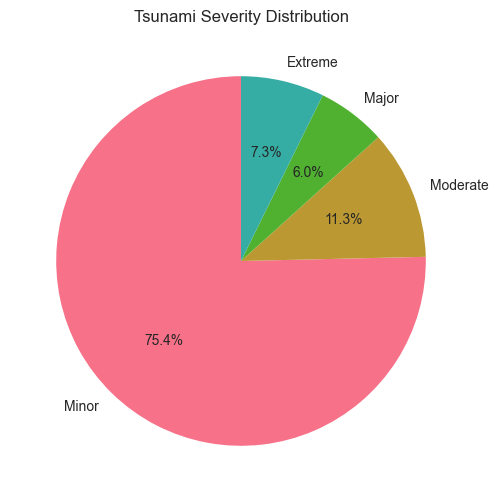

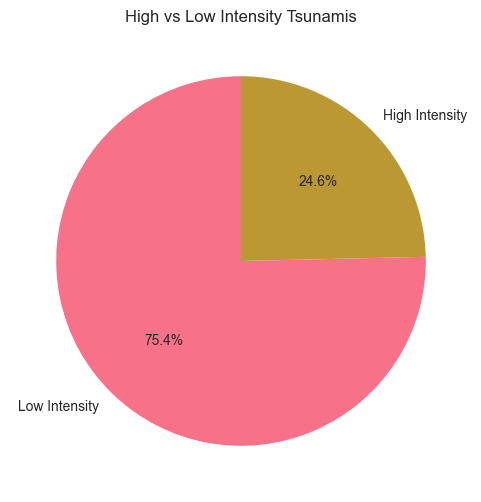

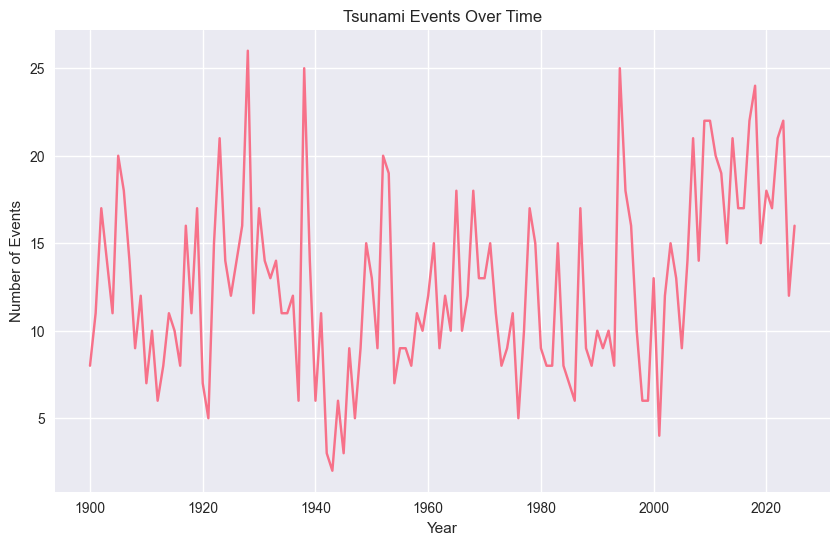

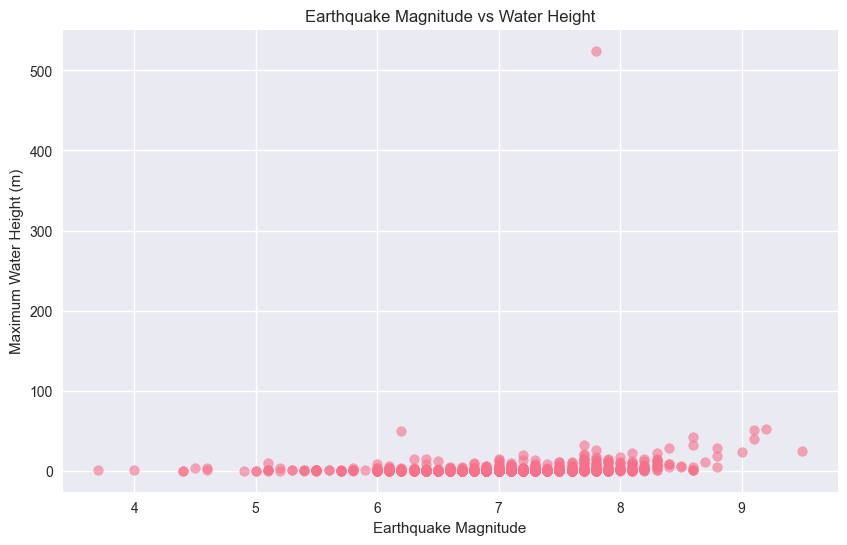

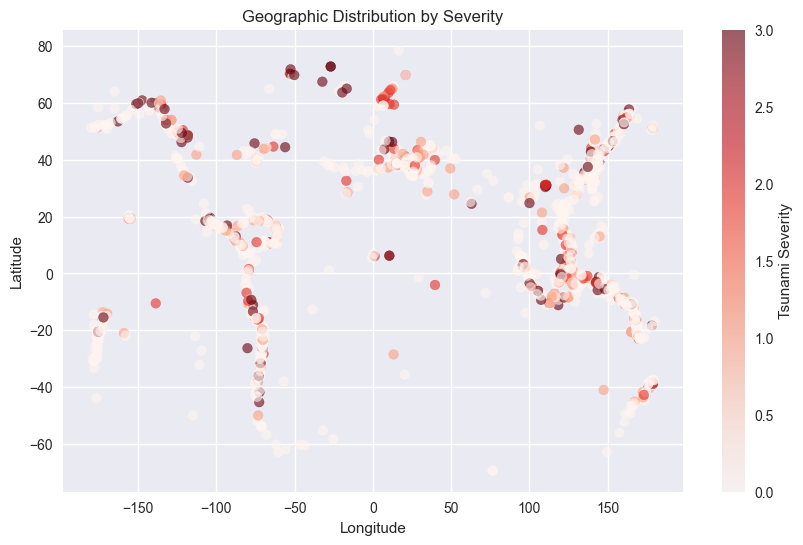

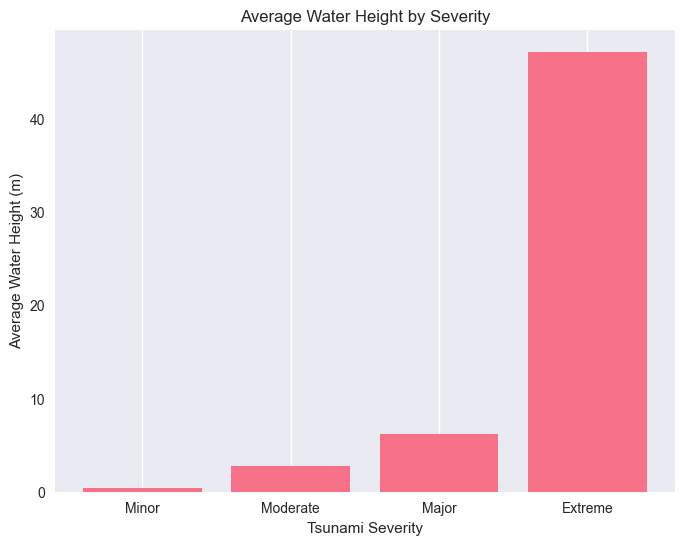


=== Correlation Analysis ===


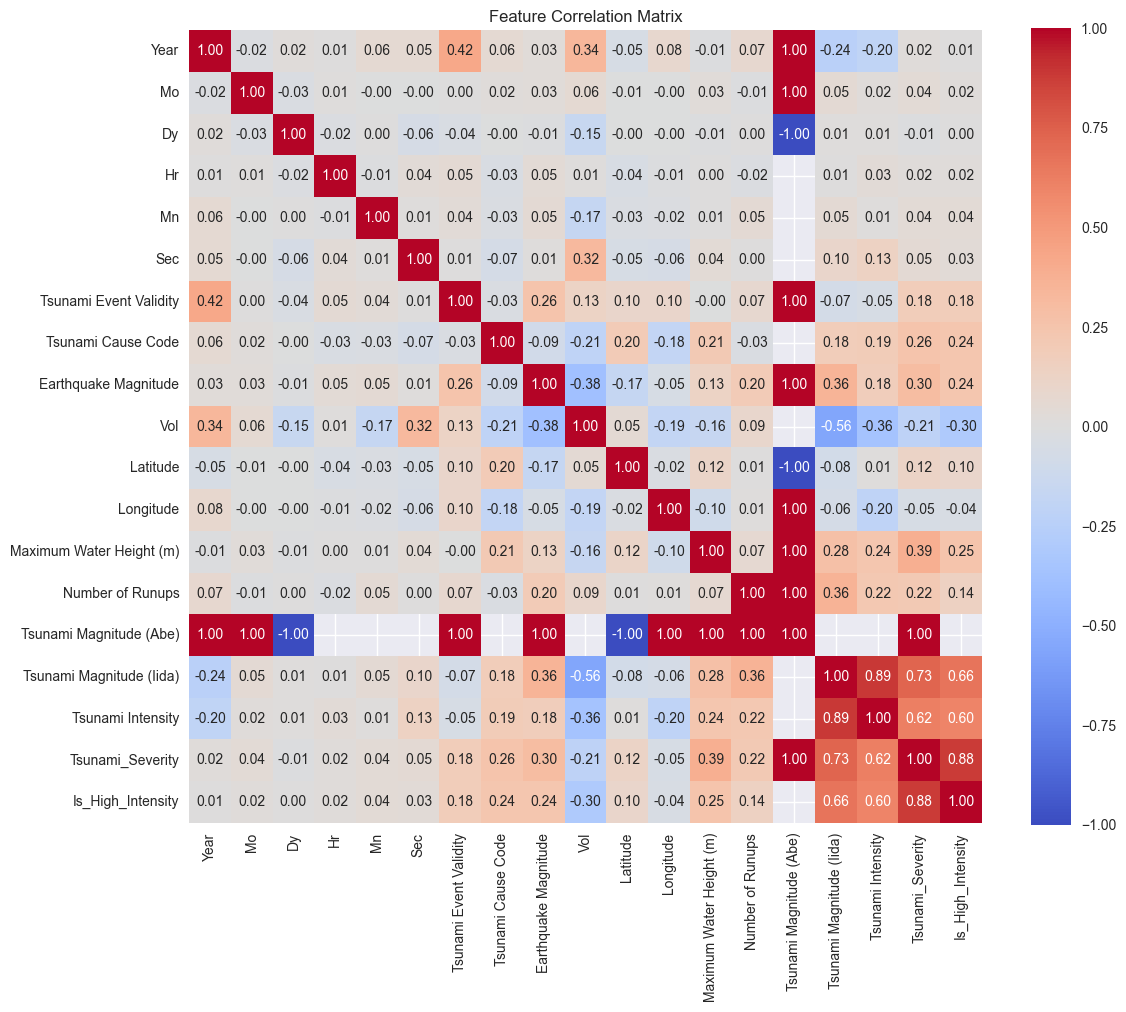

In [5]:
print("=== Data Visualization ===")

# Tsunami Severity Distribution
plt.figure(figsize=(6, 6))
plt.pie(
    df_processed["Tsunami_Severity"].value_counts().sort_index(),
    labels=["Minor", "Moderate", "Major", "Extreme"],
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Tsunami Severity Distribution")
plt.show()

# High vs Low Intensity Tsunamis
plt.figure(figsize=(6, 6))
plt.pie(
    df_processed["Is_High_Intensity"].value_counts().sort_index(),
    labels=["Low Intensity", "High Intensity"],
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("High vs Low Intensity Tsunamis")
plt.show()

# Tsunami Events Over Time
plt.figure(figsize=(10, 6))
years_counts = df_processed.groupby("Year").size()
plt.plot(years_counts.index, years_counts.values)
plt.title("Tsunami Events Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.grid(True)
plt.show()

# Earthquake Magnitude vs Water Height
valid_data = df_processed.dropna(
    subset=["Earthquake Magnitude", "Maximum Water Height (m)"]
)
if len(valid_data) > 0:
    plt.figure(figsize=(10, 6))
    plt.scatter(
        valid_data["Earthquake Magnitude"],
        valid_data["Maximum Water Height (m)"],
        alpha=0.6,
    )
    plt.xlabel("Earthquake Magnitude")
    plt.ylabel("Maximum Water Height (m)")
    plt.title("Earthquake Magnitude vs Water Height")
    plt.grid(True)
    plt.show()

# Geographic Distribution by Severity
valid_geo = df_processed.dropna(subset=["Latitude", "Longitude"])
if len(valid_geo) > 0:
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        valid_geo["Longitude"],
        valid_geo["Latitude"],
        c=valid_geo["Tsunami_Severity"],
        cmap="Reds",
        alpha=0.6,
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Geographic Distribution by Severity")
    plt.colorbar(scatter, label="Tsunami Severity")
    plt.grid(True)
    plt.show()

# Average Water Height by Severity
plt.figure(figsize=(8, 6))
severity_height = (
    df_processed.groupby("Tsunami_Severity")["Maximum Water Height (m)"]
    .mean()
    .fillna(0)
)
plt.bar(range(len(severity_height)), severity_height.values)
plt.xlabel("Tsunami Severity")
plt.ylabel("Average Water Height (m)")
plt.title("Average Water Height by Severity")
plt.xticks(range(len(severity_height)), ["Minor", "Moderate", "Major", "Extreme"])
plt.grid(axis="y")
plt.show()

print("\n=== Correlation Analysis ===")
# Feature Correlation Matrix
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
correlation_matrix = df_processed[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f"
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [6]:
print("=== Preparing Data for PyTorch ===")


class TsunamiDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.features = torch.FloatTensor(features)
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        if self.transform:
            feature = self.transform(feature)
        return feature, target


input_features = [
    "Year",
    "Mo",
    "Dy",
    "Hr",
    "Mn",
    "Sec",
    "Tsunami Event Validity",
    "Tsunami Cause Code",
    "Earthquake Magnitude",
    "Vol",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Number of Runups",
    "Tsunami Magnitude (Abe)",
    "Tsunami Magnitude (Iida)",
    "Tsunami Intensity",
]
available_input_features = [
    col for col in input_features if col in df_processed.columns
]
print(f"Using features: {available_input_features}")

X = df_processed[available_input_features].copy()
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"Feature matrix shape: {X_scaled.shape}")

y_severity = df_processed["Tsunami_Severity"].values
y_intensity = df_processed["Is_High_Intensity"].values

print(f"Target distributions:")
print(f"Severity classes: {np.bincount(y_severity)}")
print(f"Intensity classes: {np.bincount(y_intensity)}")

X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_scaled, y_severity, test_size=0.2, random_state=42, stratify=y_severity
)
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_scaled, y_intensity, test_size=0.2, random_state=42, stratify=y_intensity
)

print(f"\nData splits:")
print(f"Severity task - Train: {X_train_sev.shape[0]}, Test: {X_test_sev.shape[0]}")
print(f"Intensity task - Train: {X_train_int.shape[0]}, Test: {X_test_int.shape[0]}")

train_dataset_sev = TsunamiDataset(X_train_sev, y_train_sev)
test_dataset_sev = TsunamiDataset(X_test_sev, y_test_sev)
train_dataset_int = TsunamiDataset(X_train_int, y_train_int)
test_dataset_int = TsunamiDataset(X_test_int, y_test_int)

batch_size = 32
train_loader_sev = DataLoader(train_dataset_sev, batch_size=batch_size, shuffle=True)
test_loader_sev = DataLoader(test_dataset_sev, batch_size=batch_size, shuffle=False)
train_loader_int = DataLoader(train_dataset_int, batch_size=batch_size, shuffle=True)
test_loader_int = DataLoader(test_dataset_int, batch_size=batch_size, shuffle=False)

print(f"Data loaders created with batch size: {batch_size}")

=== Preparing Data for PyTorch ===
Using features: ['Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsunami Event Validity', 'Tsunami Cause Code', 'Earthquake Magnitude', 'Vol', 'Latitude', 'Longitude', 'Maximum Water Height (m)', 'Number of Runups', 'Tsunami Magnitude (Abe)', 'Tsunami Magnitude (Iida)', 'Tsunami Intensity']
Feature matrix shape: (1591, 17)
Target distributions:
Severity classes: [1199  180   96  116]
Intensity classes: [1199  392]

Data splits:
Severity task - Train: 1272, Test: 319
Intensity task - Train: 1272, Test: 319
Data loaders created with batch size: 32


In [7]:
class TsunamiPredictor(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(TsunamiPredictor, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend(
                [
                    nn.Linear(prev_size, hidden_size),
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_size),
                    nn.Dropout(dropout_rate),
                ]
            )
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.network(x)


input_size = X_scaled.shape[1]
model_severity = TsunamiPredictor(input_size, [64, 32], 4, 0.3).to(device)
model_intensity = TsunamiPredictor(input_size, [64, 32], 2, 0.3).to(device)

print(f"Input size: {input_size}")
print("Model for Severity Classification:")
print(model_severity)

Input size: 17
Model for Severity Classification:
TsunamiPredictor(
  (network): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [8]:
def train_model(
    model, train_loader, test_loader, num_epochs=100, learning_rate=0.001, task_name=""
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    train_losses = []
    test_accuracies = []
    best_accuracy = 0.0
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            loss = criterion(model(features), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for features, targets in test_loader:
                features, targets = features.to(device), targets.to(device)
                _, predicted = torch.max(model(features), 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), f"{task_name}_model.pth")
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Acc: {test_accuracy:.2f}%"
            )

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load(f"{task_name}_model.pth"))
    return train_losses, test_accuracies, best_accuracy


def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            _, predicted = torch.max(model(features), 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    print(classification_report(all_targets, all_predictions, target_names=class_names))
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
    return accuracy_score(all_targets, all_predictions), all_predictions, all_targets


severity_class_names = ["Minor", "Moderate", "Major", "Extreme"]
print("Training Severity Classification Model")
sev_losses, sev_accs, sev_best = train_model(
    model_severity,
    train_loader_sev,
    test_loader_sev,
    num_epochs=100,
    learning_rate=0.001,
    task_name="severity",
)
print(f"Severity Model Best Accuracy: {sev_best:.2f}%")

Training Severity Classification Model
Epoch [10/100], Loss: 0.6720, Acc: 80.56%
Epoch [20/100], Loss: 0.5830, Acc: 81.82%
Epoch [30/100], Loss: 0.5224, Acc: 82.76%
Epoch [40/100], Loss: 0.4986, Acc: 82.13%
Early stopping at epoch 47
Severity Model Best Accuracy: 83.07%


In [9]:
intensity_class_names = ["Low Intensity", "High Intensity"]
print("Training Intensity Classification Model")
int_losses, int_accs, int_best = train_model(
    model_intensity,
    train_loader_int,
    test_loader_int,
    num_epochs=100,
    learning_rate=0.001,
    task_name="intensity",
)
print(f"Intensity Model Best Accuracy: {int_best:.2f}%")

Training Intensity Classification Model
Epoch [10/100], Loss: 0.4109, Acc: 87.77%
Epoch [20/100], Loss: 0.3675, Acc: 86.83%
Early stopping at epoch 25
Intensity Model Best Accuracy: 87.77%


Evaluating Severity Classification
              precision    recall  f1-score   support

       Minor       0.85      1.00      0.92       241
    Moderate       0.58      0.19      0.29        36
       Major       0.43      0.16      0.23        19
     Extreme       0.83      0.65      0.73        23

    accuracy                           0.83       319
   macro avg       0.67      0.50      0.54       319
weighted avg       0.79      0.83      0.79       319



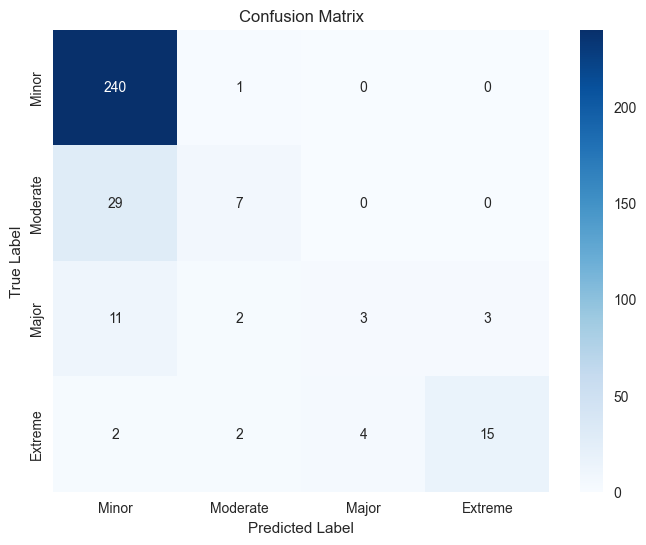


Evaluating Intensity Classification
                precision    recall  f1-score   support

 Low Intensity       0.88      0.97      0.92       240
High Intensity       0.87      0.59      0.71        79

      accuracy                           0.88       319
     macro avg       0.87      0.78      0.81       319
  weighted avg       0.88      0.88      0.87       319



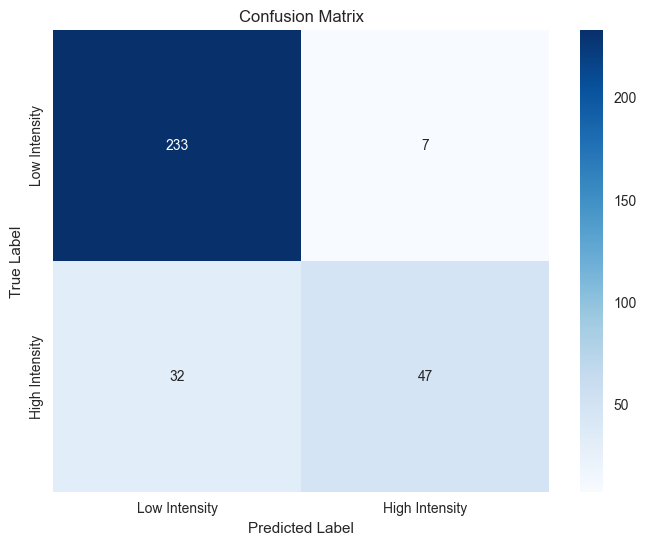

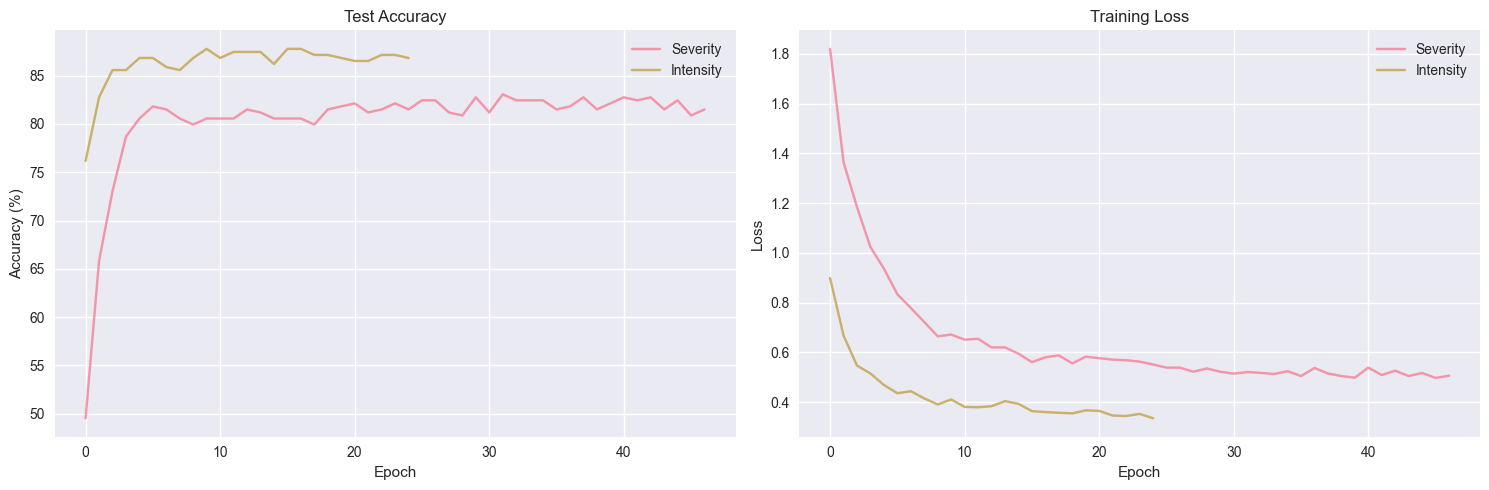

Example 1 - Mag 8.5, 8m height:
  Severity: Moderate (100.00%)
  Intensity: High Intensity (100.00%)

Example 2 - Mag 7.0, 2m height:
  Severity: Moderate (100.00%)
  Intensity: High Intensity (100.00%)

Example 3 - Pune, India (Mag 6.5, 0.5m height):
  Severity: Moderate (100.00%)
  Intensity: High Intensity (100.00%)

Models saved to 'tsunami_models.pth'


In [10]:
print("Evaluating Severity Classification")
sev_acc, sev_preds, sev_targets = evaluate_model(
    model_severity, test_loader_sev, severity_class_names
)

print("\nEvaluating Intensity Classification")
int_acc, int_preds, int_targets = evaluate_model(
    model_intensity, test_loader_int, intensity_class_names
)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(sev_accs, label="Severity", alpha=0.7)
axes[0].plot(int_accs, label="Intensity", alpha=0.7)
axes[0].set_title("Test Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy (%)")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(sev_losses, label="Severity", alpha=0.7)
axes[1].plot(int_losses, label="Intensity", alpha=0.7)
axes[1].set_title("Training Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


def predict_tsunami(
    earthquake_magnitude,
    latitude,
    longitude,
    water_height=None,
    tsunami_magnitude_abe=None,
    tsunami_magnitude_iida=None,
    intensity=None,
    year=2024,
    month=1,
    day=1,
    hour=0,
    minute=0,
    second=0,
    event_validity=4,
    cause_code=1,
    vol=0,
    num_runups=1,
):
    input_data = [
        year,
        month,
        day,
        hour,
        minute,
        second,
        event_validity,
        cause_code,
        earthquake_magnitude,
        vol,
        latitude,
        longitude,
    ]
    input_data.append(water_height if water_height is not None else 0)
    input_data.append(num_runups)
    input_data.append(tsunami_magnitude_abe if tsunami_magnitude_abe is not None else 0)
    input_data.append(
        tsunami_magnitude_iida if tsunami_magnitude_iida is not None else 0
    )
    input_data.append(intensity if intensity is not None else 0)

    while len(input_data) < input_size:
        input_data.append(0)
    input_data = input_data[:input_size]

    input_tensor = torch.FloatTensor(
        scaler.transform(imputer.transform(np.array(input_data).reshape(1, -1)))
    ).to(device)

    model_severity.eval()
    model_intensity.eval()

    with torch.no_grad():
        severity_probs = F.softmax(model_severity(input_tensor), dim=1)
        intensity_probs = F.softmax(model_intensity(input_tensor), dim=1)
        severity_pred = torch.argmax(severity_probs, dim=1).cpu().numpy()[0]
        intensity_pred = torch.argmax(intensity_probs, dim=1).cpu().numpy()[0]

    return {
        "severity": severity_class_names[severity_pred],
        "severity_confidence": f"{severity_probs.max().cpu().numpy():.2%}",
        "intensity": intensity_class_names[intensity_pred],
        "intensity_confidence": f"{intensity_probs.max().cpu().numpy():.2%}",
    }


example1 = predict_tsunami(
    earthquake_magnitude=8.5,
    latitude=35.0,
    longitude=140.0,
    water_height=8.0,
    intensity=4,
)
print("Example 1 - Mag 8.5, 8m height:")
print(f"  Severity: {example1['severity']} ({example1['severity_confidence']})")
print(f"  Intensity: {example1['intensity']} ({example1['intensity_confidence']})")

example2 = predict_tsunami(
    earthquake_magnitude=7.0,
    latitude=30.0,
    longitude=-120.0,
    water_height=2.0,
    intensity=2,
)
print("\nExample 2 - Mag 7.0, 2m height:")
print(f"  Severity: {example2['severity']} ({example2['severity_confidence']})")
print(f"  Intensity: {example2['intensity']} ({example2['intensity_confidence']})")

# Test case for Pune, India (inland city)
example3 = predict_tsunami(
    earthquake_magnitude=6.5,
    latitude=18.5204,
    longitude=73.8567,
    water_height=0.5,
    intensity=1,
)
print("\nExample 3 - Pune, India (Mag 6.5, 0.5m height):")
print(f"  Severity: {example3['severity']} ({example3['severity_confidence']})")
print(f"  Intensity: {example3['intensity']} ({example3['intensity_confidence']})")

torch.save(
    {
        "severity_model": model_severity.state_dict(),
        "intensity_model": model_intensity.state_dict(),
        "scaler": scaler,
        "imputer": imputer,
        "feature_names": available_input_features,
        "severity_classes": severity_class_names,
        "intensity_classes": intensity_class_names,
    },
    "tsunami_models.pth",
)
print("\nModels saved to 'tsunami_models.pth'")

In [11]:
# Test case for Pune, India (inland city)
example3 = predict_tsunami(
    earthquake_magnitude=6.5,
    latitude=18.5204,
    longitude=73.8567,
    water_height=0.5,
    intensity=1,
)
print("\nExample 3 - Pune, India (Mag 6.5, 0.5m height):")
print(f"  Severity: {example3['severity']} ({example3['severity_confidence']})")
print(f"  Intensity: {example3['intensity']} ({example3['intensity_confidence']})")


Example 3 - Pune, India (Mag 6.5, 0.5m height):
  Severity: Moderate (100.00%)
  Intensity: High Intensity (100.00%)
